## Resultado 1


Gráfico salvo: plots/resultado1.pdf


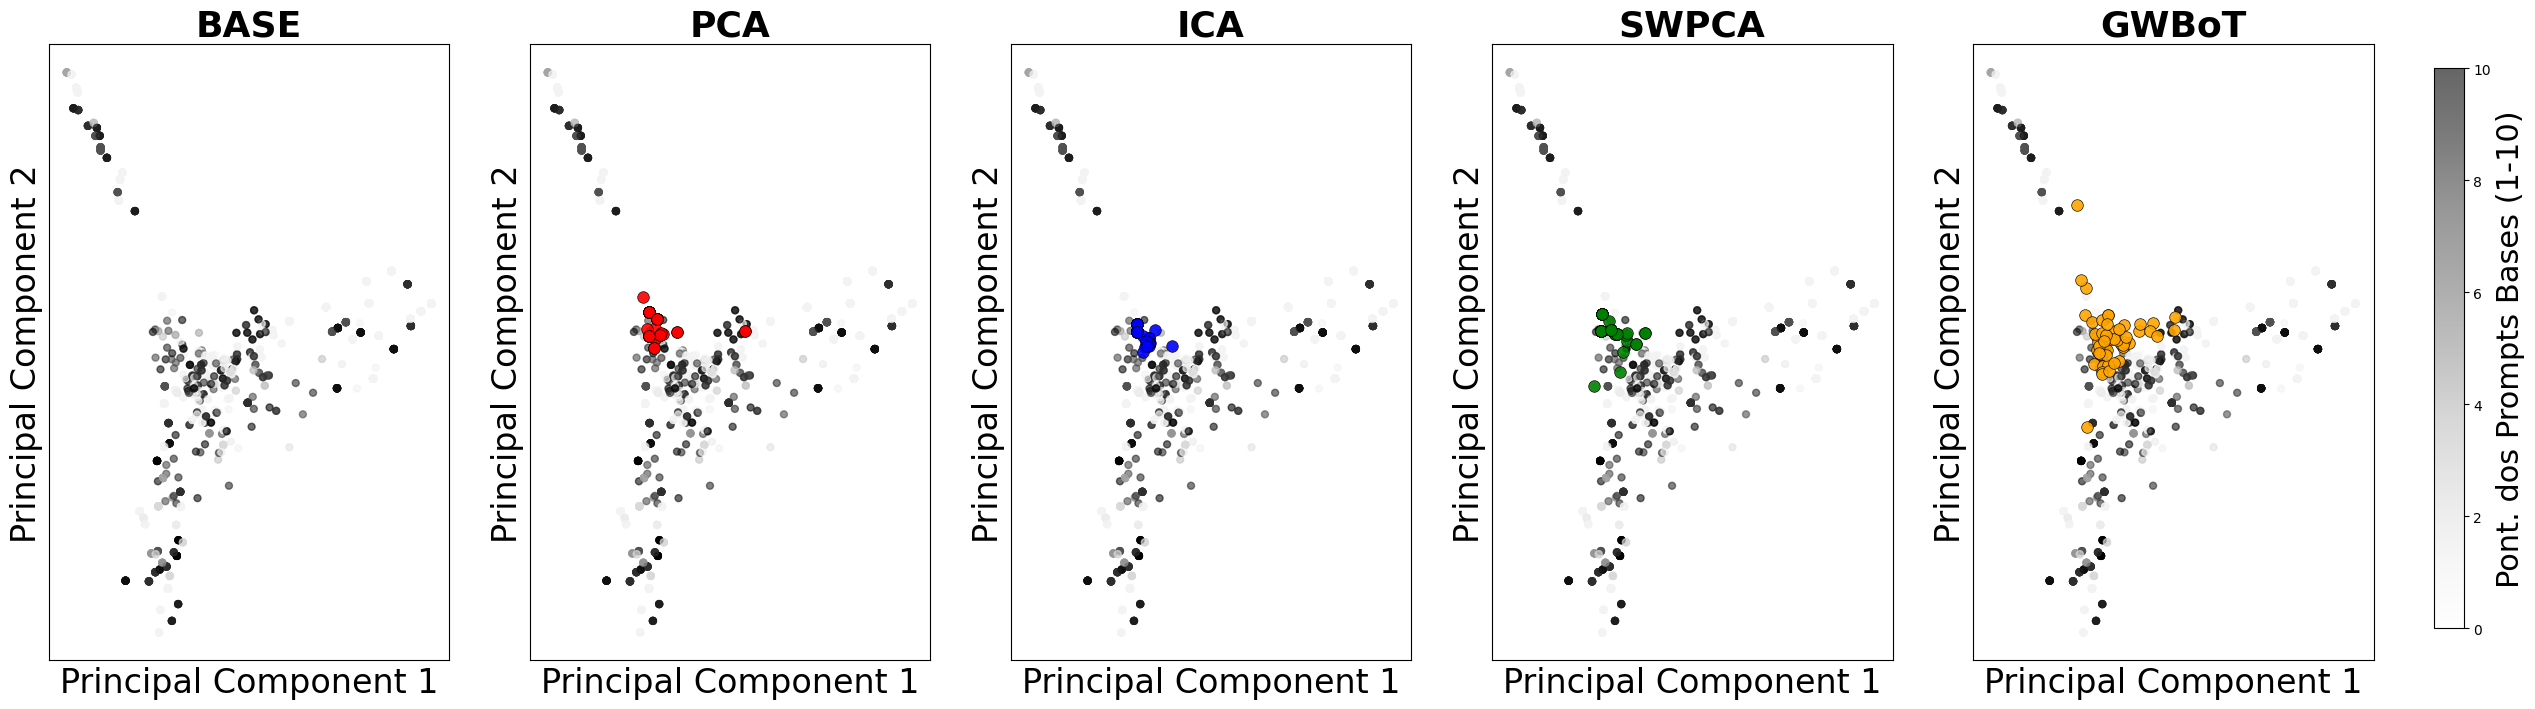

In [8]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 1. Load Data
try:
    with open('final_results_without_metrics.json', 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Erro: Arquivo 'final_results_without_metrics.json' não encontrado.")
    data = {}

if data:
    texts = []
    labels = []
    scores = []  
    
    methods = ['pca', 'ica', 'score_weighted_pca', 'gradient_weighted']
    method_names = {
        'pca': 'PCA BoT',
        'ica': 'ICA BoT',
        'score_weighted_pca': 'SWPCA BoT',
        'gradient_weighted': 'GWBoT'
    }

    
    for request_id in range(50):
        str_id = str(request_id)
        if str_id not in data.get('pca', {}):
            continue

        gw_data = data.get('gradient_weighted', {}).get(str_id, {})
        base_prompts = gw_data.get('base_prompts', [])
        base_scores_list = gw_data.get('base_scores', [])
        
        if len(base_scores_list) != len(base_prompts):
            # Fallback: assume mean or 1 if missing. 
            # But let's try to use what matches.
            pass

        for i, bp in enumerate(base_prompts):
            texts.append(bp)
            labels.append('Base Prompts')
            
            s = base_scores_list[i] if i < len(base_scores_list) else 1
            scores.append(s)
            
        
        for method in methods:
            if str_id in data.get(method, {}):
                bot_list = data[method][str_id].get('BoT', [])
                if bot_list:
                    bot_str = " ".join(bot_list)
                    texts.append(bot_str)
                    labels.append(method_names[method])
                    scores.append(0) # Placeholder for methods (not used for coloring base prompts)

    
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)

    
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X.toarray())
    
    
    df_pca = pd.DataFrame(X_pca_2d, columns=['x', 'y'])
    df_pca['label'] = labels
    df_pca['score'] = scores

    
    # --- ALTERAÇÃO AQUI: Mudamos para 5 subplots e aumentamos a largura ---
    fig, axes = plt.subplots(1, 5, figsize=(30, 8))
    
    
    x_min, x_max = df_pca['x'].min(), df_pca['x'].max()
    y_min, y_max = df_pca['y'].min(), df_pca['y'].max()
    margin_x = (x_max - x_min) * 0.05
    margin_y = (y_max - y_min) * 0.05
    
    # --- ALTERAÇÃO AQUI: Adicionado o primeiro item como (None, None, 'Base Distribution') ---
    plot_configs = [
        (None, None, 'BASE'), # Primeiro gráfico apenas com a base
        ('PCA BoT', 'red', 'PCA'),
        ('ICA BoT', 'blue', 'ICA'),
        ('SWPCA BoT', 'green', 'SWPCA'),
        ('GWBoT', 'orange', 'GWBoT')
    ]
    
    for i, (method_label, color, title) in enumerate(plot_configs):
        ax = axes[i]
        
        # 1. Plotar Base Prompts (Sempre acontece, em todos os gráficos)
        base_data = df_pca[df_pca['label'] == 'Base Prompts']
        
        sc = ax.scatter(
            base_data['x'], base_data['y'],
            c=base_data['score'], 
            cmap='Greys', 
            vmin=0, vmax=10,  
            alpha=0.6,        
            s=25, 
            label='Base Prompts (Score)',
            rasterized=True
        )
        
        # --- ALTERAÇÃO AQUI: Plotar o método apenas se method_label não for None ---
        if method_label is not None:
            method_data = df_pca[df_pca['label'] == method_label]
            ax.scatter(
                method_data['x'], method_data['y'],
                c=color, alpha=0.9, s=70, label=title,
                edgecolors='k', linewidth=0.5
            )
        
      
        ax.set_title(title, fontsize=26, fontweight='bold')
        ax.set_xlabel('Principal Component 1', fontsize=24)
        ax.set_ylabel('Principal Component 2', fontsize=24)
        
        ax.set_xlim(x_min - margin_x, x_max + margin_x)
        ax.set_ylim(y_min - margin_y, y_max + margin_y)
        
        ax.set_xticks([])
        ax.set_yticks([])

    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7]) # [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Pont. dos Prompts Bases (1-10)', fontsize=22)

    plt.subplots_adjust(right=0.9)

    output_filename = "plots/resultado1.pdf"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo: {output_filename}")

else:
    print("Sem dados.")

## Resultado 2

Method keys found: ['pca', 'ica', 'score_weighted_pca', 'gradient_weighted']


/tmp/ipykernel_20281/2038182229.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)


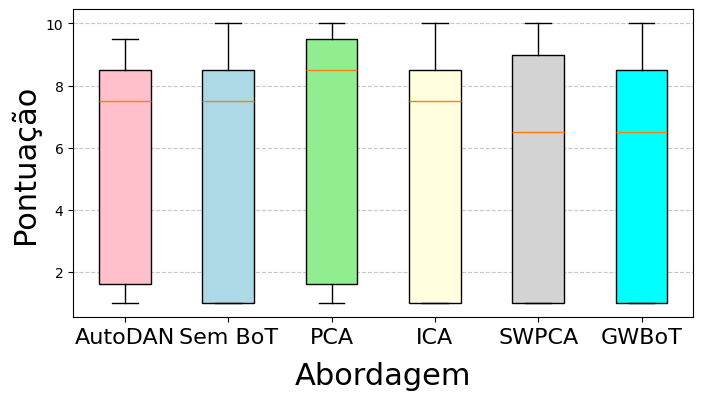

In [14]:
import json
import matplotlib.pyplot as plt

# Load files
with open("adn_attack_logs.json", "r") as f:
    autodan_data = json.load(f)

with open("final_results_base_test.json", "r") as f:
    base_test_data = json.load(f)

with open("final_results_without_metrics.json", "r") as f:
    methods_data = json.load(f)

# Get method keys to decide on renaming
method_keys = list(methods_data.keys())
print("Method keys found:", method_keys)

# Define a mapping for better display
name_mapping = {
    'pca': 'PCA',
    'ica': 'ICA',
    'score_weighted_pca': 'SWPCA',
    'gradient_weighted': 'GWBoT',
    # Add generic fallback just in case
}

def format_label(key):
    # Use mapping if exists
    if key in name_mapping:
        return name_mapping[key]
    # Fallback: replace underscores with spaces and title case
    return key.replace('_', ' ').title()

# Extract scores
data_to_plot = []
labels = []

# 1. AutoDAN
autodan_scores = [entry.get('score', 0) for entry in autodan_data if 'score' in entry]
data_to_plot.append(autodan_scores)
labels.append("AutoDAN")

# 2. Base Test
base_scores = []
for entry in base_test_data:
    if 'scores' in entry:
        base_scores.extend(entry['scores'])
data_to_plot.append(base_scores)
labels.append("Sem BoT")

# 3. Other Approaches
for method_name in method_keys:
    method_content = methods_data[method_name]
    method_scores = []
    for key, entry in method_content.items():
        if isinstance(entry, dict) and 'scores' in entry:
            method_scores.extend(entry['scores'])
    
    data_to_plot.append(method_scores)
    # Apply renaming here
    labels.append(format_label(method_name))

# Plotting
plt.figure(figsize=(8, 4))
bplot = plt.boxplot(data_to_plot, patch_artist=True, labels=labels)

colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan', 'orange', 'purple']
for i, patch in enumerate(bplot['boxes']):
    color = colors[i % len(colors)]
    patch.set_facecolor(color)

plt.ylabel('Pontuação', fontsize=22)
plt.xlabel('Abordagem', fontsize=22, labelpad=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=16)

output_filename = 'plots/scores_comparison_boxplot_.pdf'
plt.savefig(output_filename, bbox_inches='tight')



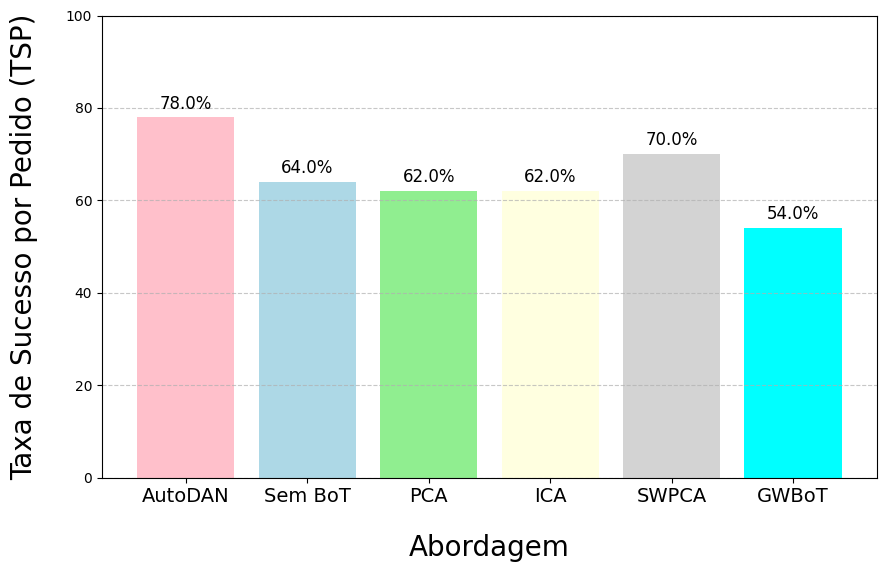

In [11]:
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'AutoDAN': 78.0,
    'Sem BoT': 64.0,
    'PCA': 62.0,
    'ICA': 62.0,
    'SWPCA': 70.0,
    'GWBoT': 54.0
}

labels = list(data.keys())
values = list(data.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan'])

# Add title and axis labels
plt.ylabel('Taxa de Sucesso por Pedido (TSP)', fontsize=20, labelpad=20)
plt.xlabel('Abordagem', fontsize=20, labelpad=20)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=12)

# Adjust layout
plt.ylim(0, 100)  # Assuming percentage goes up to 100
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.xticks(fontsize=14)
# Save the plot
output_filename = 'plots/tsp_comparison_barchart.pdf'
plt.savefig(output_filename, bbox_inches='tight')


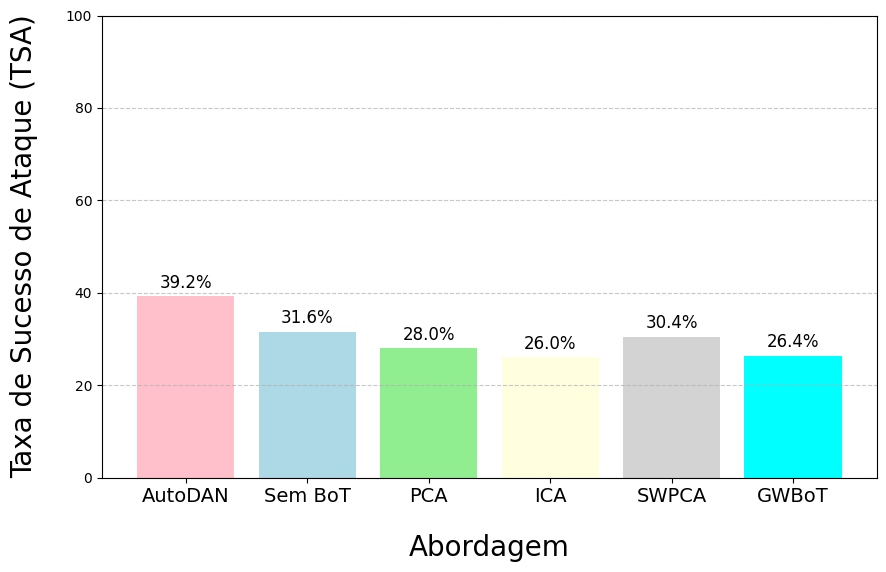

In [12]:
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'AutoDAN': 39.2,
    'Sem BoT': 31.6,
    'PCA': 28.0,
    'ICA': 26.0,
    'SWPCA': 30.4,
    'GWBoT': 26.4
}

labels = list(data.keys())
values = list(data.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgrey', 'cyan'])

# Add title and axis labels
plt.ylabel('Taxa de Sucesso de Ataque (TSA)', fontsize=20, labelpad=20)
plt.xlabel('Abordagem', fontsize=20, labelpad=20)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=12)

# Adjust layout
plt.ylim(0, 100)  # Assuming percentage goes up to 100
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.xticks(fontsize=14)
# Save the plot
output_filename = 'plots/tsa_comparison_barchart.pdf'
plt.savefig(output_filename, bbox_inches='tight')


In [ ]:
### Resultado 